## Deep Learning with PyTorch : Neural Style Transfer

In [3]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading VGG Pretrained Model

In [4]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained = True)

In [5]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [9]:
from PIL import Image
from torchvision import transforms as T
def preprocess(img_path,max_size =500):
  image = Image.open(img_path).convert('RGB')
  if max(image.size)>max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
                               
              ])
  
  image = img_transforms(image)
  image = image.unsqueeze(0)
  return image


In [10]:
content_p = preprocess('/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer: Pytorch/Image /R.jpg')
style_p = preprocess('/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer: Pytorch/Image /2103_1.jpg')



content_p = content_p.to(device)
style_p = style_p.to(device)



print('con_p',content_p.shape)
print('sty_p',style_p.shape)

con_p torch.Size([1, 3, 500, 740])
sty_p torch.Size([1, 3, 500, 500])


## Deprocess image

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.numpy()
  image = image.squeeze(0) #(1,3,224,224) > (3,224,224)
  image = image.transpose(1,2,0)  #(3,224,224 ) >(224,224,3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)
  return image

In [12]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)


print('cont_d',content_d.shape)
print('sty_d',style_d.shape)

cont_d (500, 740, 3)
sty_d (500, 500, 3)


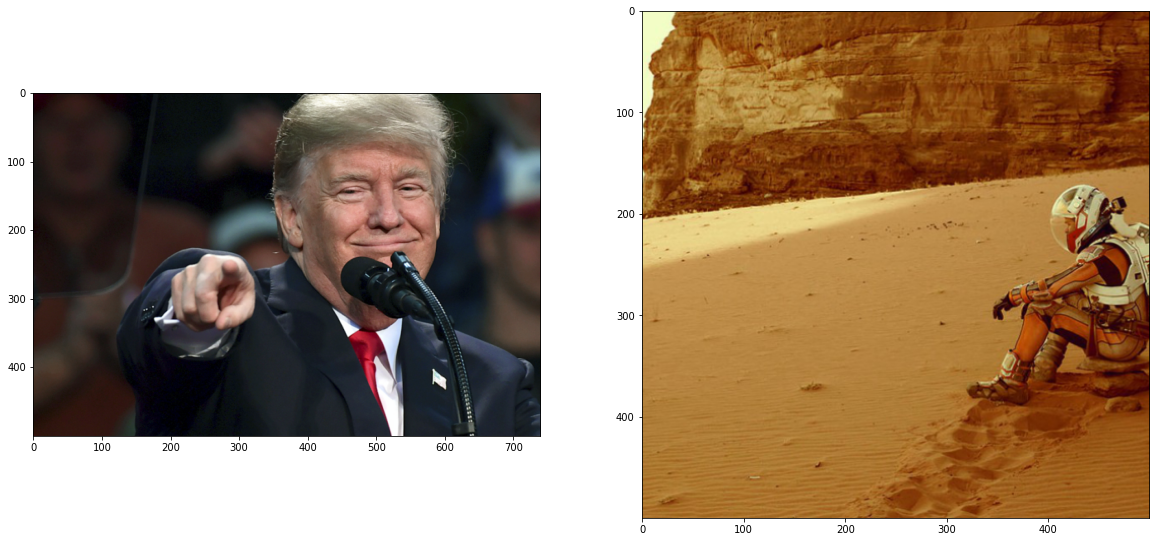

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

## Get content,style features and create gram matrix

In [14]:
def get_features(image,model):
  layers =  {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #content feature
      '28' : 'conv5_1'

  }
  x = image
  features = {}

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features



In [15]:
content_f = get_features(content_p,vgg)
style_f = get_features(style_p,vgg)

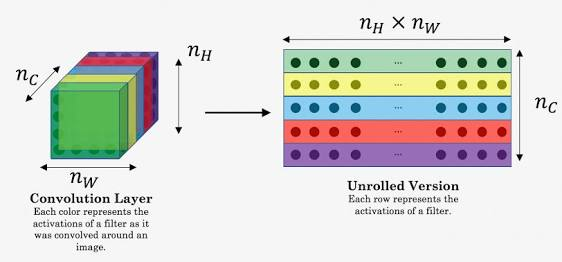

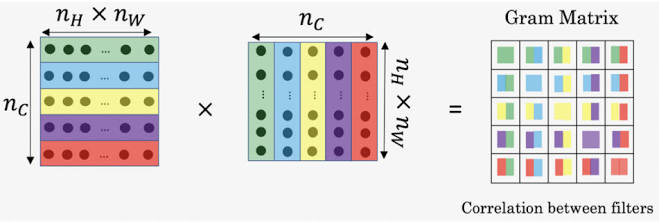

In [16]:
def gram_matrix (tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram


In [17]:
style_gram = {layer : gram_matrix(style_f[layer]) for layer in style_f}

## Creating Style and Content loss function

In [18]:
def content_loss(target_conv4_2,content_conv4_2):

  loss= torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [19]:
style_weights = {
    'conv1_1':1.0,
    'conv2_1':0.75,
    'conv3_1':0.2,
    'conv4_1':0.2,
    'conv5_1':0.2
}

In [20]:
def style_loss(style_weights,target_features,style_grams):

  loss = 0
  
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss= style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [21]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("Content Loss: ",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss:", style_loss(style_weights,target_f,style_gram))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss: tensor(140.2745, device='cuda:0', grad_fn=<AddBackward0>)


## Task 7 : Training loop

In [22]:
from torch import optim
optimizer = optim.Adam([target], lr=0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every=500

In [23]:
def total_loss(c_loss, s_loss, alpha,beta):
  loss= alpha * c_loss + beta * s_loss
  return loss

In [24]:
results = []

for i in range(epochs):
  
  target_f = get_features(target,vgg)

  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_gram)
  t_loss = total_loss(c_loss, s_loss,alpha,beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print("Total Loss at Epoch {}: {}".format(i,t_loss))
    results.append(deprocess(target.detach()))

Total Loss at Epoch 0: 14027452.0
Total Loss at Epoch 500: 1183468.375
Total Loss at Epoch 1000: 513035.75
Total Loss at Epoch 1500: 372746.6875
Total Loss at Epoch 2000: 314040.3125
Total Loss at Epoch 2500: 277377.0


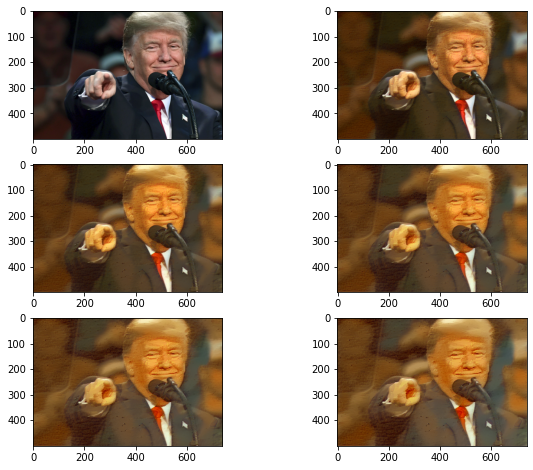

In [25]:
plt.figure(figsize =(10,8))

for i in range(len(results)):
  
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

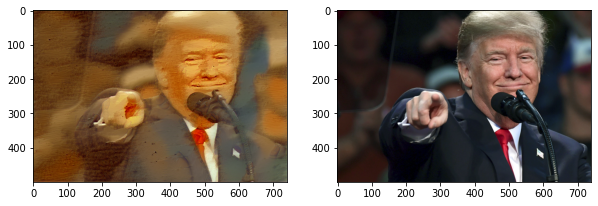

In [26]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)